## CSML1010 Group3 Course_Project - Milestone 1 - Feature Engineering and Selection
#### Authors (Group3): Paul Doucet, Jerry Khidaroo
#### Project Repository: https://github.com/CSML1010-3-2020/NLPCourseProject

#### Dataset:
The dataset used in this project is the __Taskmaster-1__ dataset from Google.
[Taskmaster-1](https://research.google/tools/datasets/taskmaster-1/)

The dataset can be obtained from: https://github.com/google-research-datasets/Taskmaster

#### Import Libraries

In [1]:
# import pandas, numpy
import pandas as pd
import numpy as np
import re
import nltk


#### Set Some Defaults

In [2]:
# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = None

# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

## 1. Data Preparation

#### Load Data

In [3]:
import sqlite3

sql = """
SELECT p.*
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df = pd.read_sql_query(sql, con)

#### Get relevant columns

In [4]:
sql = """
SELECT p.selfdialog_clean, p.instruction_id
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df_all = pd.read_sql_query(sql, con)

Down sample to 1000 records.

In [5]:
print ((1000 * 1000)//7708)

129


In [6]:
# Get 50 per instruction_id then reduce to 1000
def sampling_k_elements(group, k=130):
    if len(group) < k:
        return group
    return group.sample(k)

#Get balanced samples
corpus_df = df_all.groupby('Instruction_id').apply(sampling_k_elements).reset_index(drop=True)

#Reduce to 1000
corpus_df = corpus_df.sample(n=1000, random_state=1)
print (corpus_df.groupby('Instruction_id').size())

Instruction_id
auto-repair-appt-1    78
coffee-ordering-1     73
coffee-ordering-2     79
movie-finder          36
movie-tickets-1       80
movie-tickets-2       79
movie-tickets-3       76
pizza-ordering-1      70
pizza-ordering-2      81
restaurant-table-1    72
restaurant-table-2    73
restaurant-table-3    65
uber-lyft-1           71
uber-lyft-2           67
dtype: int64


#### Create Factorized 'category' column from 'Instruction_id' label column.

In [7]:
corpus_df['category'] = corpus_df['Instruction_id'].factorize()[0]
corpus_df.head(5)

,selfdialog_clean,Instruction_id,category
111,"Can you set up an appointment for my car Yes, which car would you like to set that up for? My 2012 Chevrolet Traverse Where would you like me to set up that appointmet? Intelligent Auto Solutions Ok setting up appointment for auto repair at Intelligent Auto Solutions in Buffalo New York. What type of repair? I need to change my tire, I have a donut on my car Ok, the next available appointment is Thursday at 2pm That doesn't work, I need the appointment for today or tomorow Ok, the next emergency appointment is tomorrow at 7am Ill take it What is your address? 510 fairway avenue, buffalo nY 12252 What is the best number to reach you? 201-555-5555 what is your email? heatherfelix@yahoo.com Ok, confirming for 2012 chevy traverse tire repair at Intelligent auto solutions tomorrow at 7am. Please be advised of an estimated cost of 180 for this service. Service for Heather Blake Thank you yOure welcome",auto-repair-appt-1,0
126,"I need to get my Subaru in to the shop as soon as possible. What time were you looking for the appointment? Tomorrow, for 9am. Confirming for Wednesday 01/22/2019 at 9am. What vehicle make and model? 1997 Subaru Legacy. What services do you require? A standard oil change, and my brakes are having issues. Standard oil or premium oil? I'd prefer standard. What is the brake issue you're experiencing? My brakes are squealing quite a bit when I press the pedal. Confirming, squealing brakes. Yes, what is the estimated cost? An oil change is 30 dollars, the brakes could be anywhere from $200 - $500 depending on severity. Okay, well let's book the appointment for a diagnostic check to make sure. Booking the appointment for 9am for Wednesday 01/22/2019 for diagnostic check, brakes, and oil change. Is that correct? Yes that is correct. Lastly, did you need to schedule a pickup or a loaner vehicle? No, that's not necessary. Okay, thank you for booking the appointment through me. Is there anything else you require? No, that's all. Have a nice day. You too!",auto-repair-appt-1,0
555,"I need movie tickets for Cold Pursuit Where did you want to see that? Syracuse OK, is Destiny USA acceptable. It is showing at the Regal Cinema there. Yes that sounds good. There are shows at 6:50 pm and 9:50 pm. Which would you prefer? 9:50 OK, is it just you or are you bringing guests? I need 2 tickets. To confirm, that is 2 tickets at Regal Cinema in Destiny for Cold Pursuit at 9:50 pm this evening. Yes, how much will that be? Those are both adult tickets? Yes That will be $26.20 total. You can go ahead and order those through my account. Ordering 2 tickets to Cold Pursuit right now. Sounds great! The tickets are ordered and will be sent to your phone as a text message. I've got them. thank you! Glad to be of service.",movie-tickets-1,1
1260,"I'm in the mood for some scallops from Cappy's. Those are sooo awesome! Would you like me to make reservations for you? Yes, please. Tonight at 9 sounds good. Thanks. No problem. This is the 29th, right? Yeah. Friday the 29th. 9:00 Table for how many? 3? Or aren't you taking me too? Yeah right. Maybe next time. Tonight is just me & my man. Table for two, and make it an outdoor table please. No tables available at 9 in or outdoors How about 10 then? They are pretty much booked up on Friday Okay then- inside at 11? No good. Forget Cappy's then. They really aren't worth this much trouble. I totally agree. Where would you lke to eat instead? How about Biga on the Banks? Their food is always spectacular Awesome. Same time and outdoor there as well? Try for 10 instead. Also, I want a private table if possible. Setting it up for tonight at 10 with a private/secluded table for two. Perfect. Thanks Okay, you're all set for tonight. You have reservations for two at 10:00 at Biga. They said they'll save you a cozy table with some privacy as well. Awesome! You're the best. Next time I promise you'll be there too. I'll remember that you said that. And you are very wel

#### Word Embeddings

In [8]:
df.columns

Index(['index', 'id', 'Conversation', 'Instruction_id', 'service_type',
       'selfdialog_clean', 'selfdialog_lemma', 'selfdialog_nouns',
       'selfdialog_adjectives', 'selfdialog_verbs', 'selfdialog_nav',
       'no_tokens'],
      dtype='object')

In [9]:
corpus_df.columns

Index(['selfdialog_clean', 'Instruction_id', 'category'], dtype='object')

#### Do Some Additional CLeaning

In [10]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    #doc = "'" + doc + "'"
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    #doc = [[word.lower() for word in sent if word not in remove_terms] for sent in doc]
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [11]:
for i, row in corpus_df.iterrows():
    corpus_df.at[i, "selfdialog_norm"] = normalize_corpus(row.selfdialog_clean) 

corpus_df.head(3)

,selfdialog_clean,Instruction_id,category,selfdialog_norm
111,"Can you set up an appointment for my car Yes, which car would you like to set that up for? My 2012 Chevrolet Traverse Where would you like me to set up that appointmet? Intelligent Auto Solutions Ok setting up appointment for auto repair at Intelligent Auto Solutions in Buffalo New York. What type of repair? I need to change my tire, I have a donut on my car Ok, the next available appointment is Thursday at 2pm That doesn't work, I need the appointment for today or tomorow Ok, the next emergency appointment is tomorrow at 7am Ill take it What is your address? 510 fairway avenue, buffalo nY 12252 What is the best number to reach you? 201-555-5555 what is your email? heatherfelix@yahoo.com Ok, confirming for 2012 chevy traverse tire repair at Intelligent auto solutions tomorrow at 7am. Please be advised of an estimated cost of 180 for this service. Service for Heather Blake Thank you yOure welcome",auto-repair-appt-1,0,set appointment car yes car would like set chevrolet traverse would like set appointmet intelligent auto solutions ok setting appointment auto repair intelligent auto solutions buffalo new york type repair need change tire donut car ok next available appointment thursday pm doesnt work need appointment today tomorow ok next emergency appointment tomorrow ill take address fairway avenue buffalo ny best number reach email heatherfelixyahoocom ok confirming chevy traverse tire repair intelligent auto solutions tomorrow please advised estimated cost service service heather blake thank youre welcome
126,"I need to get my Subaru in to the shop as soon as possible. What time were you looking for the appointment? Tomorrow, for 9am. Confirming for Wednesday 01/22/2019 at 9am. What vehicle make and model? 1997 Subaru Legacy. What services do you require? A standard oil change, and my brakes are having issues. Standard oil or premium oil? I'd prefer standard. What is the brake issue you're experiencing? My brakes are squealing quite a bit when I press the pedal. Confirming, squealing brakes. Yes, what is the estimated cost? An oil change is 30 dollars, the brakes could be anywhere from $200 - $500 depending on severity. Okay, well let's book the appointment for a diagnostic check to make sure. Booking the appointment for 9am for Wednesday 01/22/2019 for diagnostic check, brakes, and oil change. Is that correct? Yes that is correct. Lastly, did you need to schedule a pickup or a loaner vehicle? No, that's not necessary. Okay, thank you for booking the appointment through me. Is there anything else you require? No, that's all. Have a nice day. You too!",auto-repair-appt-1,0,need get subaru shop soon possible time looking appointment tomorrow confirming wednesday vehicle make model subaru legacy services require standard oil change brakes issues standard oil premium oil id prefer standard brake issue youre experiencing brakes squealing quite bit press pedal confirming squealing brakes yes estimated cost oil change dollars brakes could anywhere depending severity okay well lets book appointment diagnostic check make sure booking appointment wednesday diagnostic check brakes oil change correct yes correct lastly need schedule pickup loaner vehicle thats necessary okay thank booking appointment anything else require thats nice day
555,"I need movie tickets for Cold Pursuit Where did you want to see that? Syracuse OK, is Destiny USA acceptable. It is showing at the Regal Cinema there. Yes that sounds good. There are shows at 6:50 pm and 9:50 pm. Which would you prefer? 9:50 OK, is it just you or are you bringing guests? I need 2 tickets. To confirm, that is 2 tickets at Regal Cinema in Destiny for Cold Pursuit at 9:50 pm this evening. Yes, how much will that be? Those are both adult tickets? Yes That will be $26.20 total. You can go ahead and order those through my account. Ordering 2 tickets to Cold Pursuit right now. Sounds great! The tickets are ordered and will be s

In [12]:
doc_lst = []
for i, row in corpus_df.iterrows():
    doc_lst.append(row.selfdialog_norm.tolist())

print(len(doc_lst))
doc_lst[1:5]

1000


['need get subaru shop soon possible time looking appointment tomorrow confirming wednesday vehicle make model subaru legacy services require standard oil change brakes issues standard oil premium oil id prefer standard brake issue youre experiencing brakes squealing quite bit press pedal confirming squealing brakes yes estimated cost oil change dollars brakes could anywhere depending severity okay well lets book appointment diagnostic check make sure booking appointment wednesday diagnostic check brakes oil change correct yes correct lastly need schedule pickup loaner vehicle thats necessary okay thank booking appointment anything else require thats nice day',
 'need movie tickets cold pursuit want see syracuse ok destiny usa acceptable showing regal cinema yes sounds good shows pm pm would prefer ok bringing guests need tickets confirm tickets regal cinema destiny cold pursuit pm evening yes much adult tickets yes total go ahead order account ordering tickets cold pursuit right sound

#### Build Vocabulary

In [13]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer(lower=False)
tokenizer.fit_on_texts(doc_lst)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in doc_lst]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Using TensorFlow backend.
Vocabulary Size: 5805
Vocabulary Sample: [('like', 1), ('would', 2), ('ok', 3), ('okay', 4), ('yes', 5), ('pm', 6), ('want', 7), ('order', 8), ('thank', 9), ('tickets', 10)]


#### Build (context_words, target_word) pair generator

In [14]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [15]:
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['set', 'appointment', 'yes', 'car'] -> Target (Y): car
Context (X): ['appointment', 'car', 'car', 'would'] -> Target (Y): yes
Context (X): ['car', 'yes', 'would', 'like'] -> Target (Y): car
Context (X): ['yes', 'car', 'like', 'set'] -> Target (Y): would
Context (X): ['car', 'would', 'set', 'chevrolet'] -> Target (Y): like
Context (X): ['would', 'like', 'chevrolet', 'traverse'] -> Target (Y): set
Context (X): ['like', 'set', 'traverse', 'would'] -> Target (Y): chevrolet
Context (X): ['set', 'chevrolet', 'would', 'like'] -> Target (Y): traverse
Context (X): ['chevrolet', 'traverse', 'like', 'set'] -> Target (Y): would
Context (X): ['traverse', 'would', 'set', 'appointmet'] -> Target (Y): like
Context (X): ['would', 'like', 'appointmet', 'intelligent'] -> Target (Y): set


#### Set up Dictionaries to Cross-Refrence 'Instruction_id' and its Factorized value 'category'

In [16]:
category_id_df = corpus_df[['Instruction_id', 'category']].drop_duplicates().sort_values('category')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category', 'Instruction_id']].values)

#### Split Data into Train and Test Sets

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(doc_lst, corpus_df['Instruction_id'], test_size=0.25, random_state = 0)

## Bag of Words Feature Extraction

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1., vocabulary=word2id)
cv_matrix = cv.fit_transform(doc_lst)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 2, 2, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 2, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 6, 5, ..., 0, 0, 0]], dtype=int64)

In [19]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,PAD,like,would,ok,okay,yes,pm,want,order,thank,tickets,time,please,great,one,...,fdr,ramada,oasis,northwest,mostly,wicked,cheapskate,desires,companies,taxilyft,classier,miserable,ass,spa,massage
0,0,2,2,4,0,1,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,2,2,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,2,0,3,3,1,1,1,6,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,2,0,2,1,0,1,0,0,0,3,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,3,1,0,2,1,0,0,0,1,4,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,3,2,0,5,1,0,0,1,1,0,0,0,2,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
996,0,1,1,0,2,2,3,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
997,0,1,2,2,0,0,0,0,0,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
998,0,0,0,0,0,0,0,7,0,1,0,3,0,0,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [20]:
# Get BOW features
X_train_bow = cv.fit_transform(X_train).toarray()
X_test_bow = cv.transform(X_test).toarray()
print (X_train_bow.shape) 
print (X_test_bow.shape) 
print (y_test.shape)

(750, 5805)
(250, 5805)
(250,)


#### Define Model Builder Function

In [21]:
#from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def Build_Model(model, features_train, labels_train, features_test, labels_test):
    classifier = model.fit(features_train, labels_train)

    # Predicter to output
    pred = classifier.predict(features_test)

    # Metrics to output
    cm = confusion_matrix(pred,labels_test)
    report = metrics.classification_report(labels_test, pred)
    f1 = metrics.f1_score(labels_test, pred, average='weighted')
    accuracy = cm.trace()/cm.sum()

    return cm, pred, f1, report, accuracy

## Bag of Words Feature Benchmarking Baseline with Naive Bayes Classifier

In [22]:
from sklearn.naive_bayes import MultinomialNB

model_nb_bow = MultinomialNB()
cm_nb_bow, pred_nb_bow, f1_nb_bow, report_nb_bow, accuracy_nb_bow = Build_Model(model_nb_bow, X_train_bow, y_train, X_test_bow, y_test)

In [23]:
# Save benchmark output
rows_benchmarks = []
rows_benchmarks.append(["BOW Naive Bayes All Features", f1_nb_bow, accuracy_nb_bow])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.63,0.64


In [24]:
from sklearn.metrics import confusion_matrix

cm_nb_bow

array([[17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  5,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 14, 13,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 16,  2,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  1,  4, 17,  9,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  3, 14,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  3,  7,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  9, 16,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  3,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0, 11, 13, 10,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  6,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11,  4],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  9]],
      dtype=int64)

In [25]:
from sklearn import metrics

print("Label" + report_nb_bow)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      0.94      0.97        18
 coffee-ordering-1       0.71      0.26      0.38        19
 coffee-ordering-2       0.45      0.81      0.58        16
      movie-finder       1.00      0.82      0.90        11
   movie-tickets-1       0.84      0.80      0.82        20
   movie-tickets-2       0.53      0.77      0.63        22
   movie-tickets-3       0.78      0.58      0.67        24
  pizza-ordering-1       0.30      0.21      0.25        14
  pizza-ordering-2       0.64      0.70      0.67        23
restaurant-table-1       0.77      0.45      0.57        22
restaurant-table-2       0.37      0.76      0.50        17
restaurant-table-3       0.75      0.38      0.50        16
       uber-lyft-1       0.73      0.73      0.73        15
       uber-lyft-2       0.69      0.69      0.69        13

          accuracy                           0.64       250
         macro avg       0.68    

## Feature Selection: BOW Features with Naive Bayes Model Using Chi-Squared Selector

#### Define Feature Selection Function

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

def SelectBestModelFeatures_Chi(model, num_feats, features_train, labels_train, features_test, labels_test):
    X_norm = MinMaxScaler().fit_transform(features_train, labels_train)
    #X_norm = MinMaxScaler(feature_range=(0,1), copy=True).fit_transform(features_train, labels_train)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, labels_train)
    chi_support = chi_selector.get_support()
    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]
    classifier_chi = model.fit(X_train_chi, labels_train)

    # Predicter to output
    predict_chi = classifier_chi.predict(X_test_chi)

    # Metrics to output
    cm_chi = confusion_matrix(predict_chi,labels_test)
    report_chi = metrics.classification_report(labels_test, predict_chi)
    f1_chi = metrics.f1_score(labels_test, predict_chi, average='weighted')
    accuracy_chi = cm_chi.trace()/cm_chi.sum()

    return cm_chi, predict_chi, f1_chi, report_chi, accuracy_chi

#### Iterate through number of features and get benchmark results

In [27]:
rows = []
for i in range(250, 5740, 10): # range(a, b, c) will count from a to b by intervals of c.
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test)
    rows.append([i, f1_i, accuracy_i])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])


#### Plot f1-score by number of selected features

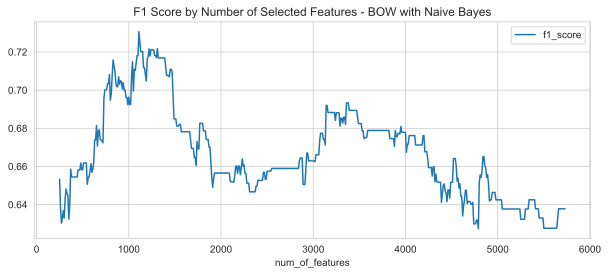

In [28]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [29]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
acc_df.sort_values(by='f1_score', ascending=False).head(5)

1060 1160 1


,num_of_features,f1_score,accuracy
86,1110,0.73,0.73
87,1120,0.72,0.73
106,1310,0.72,0.72
97,1220,0.72,0.72
100,1250,0.72,0.72


#### Get a more fine-grained look at the optimal number of features region

In [30]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test)
    rows.append([i, f1_i, accuracy_i])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

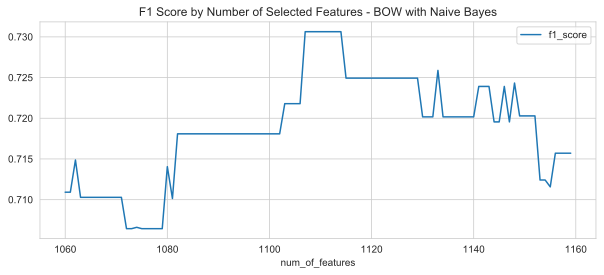

In [31]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [32]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
print(Opt_no_of_feat)
acc_df.sort_values(by='f1_score', ascending=False).head(5)

1110


,num_of_features,f1_score,accuracy
50,1110,0.73,0.73
47,1107,0.73,0.73
54,1114,0.73,0.73
53,1113,0.73,0.73
52,1112,0.73,0.73


#### Benchmark BOW With Optimal Features Selected using Naive Bayes Model

In [33]:
model_nb_bow_opt = MultinomialNB()
cm_opt_bow, pred_opt_bow, f1_opt_bow, report_opt_bow, accuracy_opt_bow = SelectBestModelFeatures_Chi(model_nb_bow_opt, Opt_no_of_feat, X_train_bow, y_train, X_test_bow, y_test)

In [34]:
print(cm_opt_bow)

[[18  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 10  3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  9 12  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 18  1  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  2 18  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  3 20  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  3  6  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  9 17  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 13  2  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  8 14  7  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  1  9  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 11  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  4 10]]


In [35]:
print("Label" + report_opt_bow)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.77      0.53      0.62        19
 coffee-ordering-2       0.52      0.75      0.62        16
      movie-finder       1.00      0.91      0.95        11
   movie-tickets-1       0.86      0.90      0.88        20
   movie-tickets-2       0.78      0.82      0.80        22
   movie-tickets-3       0.87      0.83      0.85        24
  pizza-ordering-1       0.33      0.21      0.26        14
  pizza-ordering-2       0.65      0.74      0.69        23
restaurant-table-1       0.87      0.59      0.70        22
restaurant-table-2       0.47      0.82      0.60        17
restaurant-table-3       0.82      0.56      0.67        16
       uber-lyft-1       0.79      0.73      0.76        15
       uber-lyft-2       0.71      0.77      0.74        13

          accuracy                           0.73       250
         macro avg       0.75    

In [36]:
# Save benchmark output
rows_benchmarks.append(["BOW Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), f1_opt_bow, accuracy_opt_bow])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.63,0.64
1,BOW Naive Bayes Optimal Features Selected: 1110,0.73,0.73


## Bag of N-Grams Feature Extraction

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(X_train)
bv_matrix = bv_matrix.toarray()
bv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [38]:
# get all unique words in the corpus
vocab = bv.get_feature_names()
# show document feature vectors
pd.DataFrame(bv_matrix, columns=vocab)

,aaa ok,abcs chicken,abcs yes,abgout second,ability order,able accommodate,able assist,able book,able check,able get,able help,able look,able make,able monitor,able negotiate,...,yup problem,yup thanks,yup thats,yup times,za pizza,zero ok,zip alright,zip code,zipcode dallas,zipcode would,ziti great,ziti okay,zoo philly,zucchini olive,zurich cinema
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
746,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
747,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
748,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
# Get Bag of N-Gram features
X_train_bong = bv.fit_transform(X_train).toarray()
X_test_bong = bv.transform(X_test).toarray()
print (X_train_bong.shape) 
print (X_test_bong.shape) 
print (y_test.shape)

(750, 36598)
(250, 36598)
(250,)


## Bag of N-Grams Feature Benchmarking with Naive Bayes Classifier

In [40]:
from sklearn.naive_bayes import MultinomialNB

model_nb_bong = MultinomialNB()
cm_nb_bong, pred_nb_bong, f1_nb_bong, report_nb_bong, accuracy_nb_bong = Build_Model(model_nb_bong, X_train_bong, y_train, X_test_bong, y_test)

In [41]:
# Save benchmark output
rows_benchmarks.append(["Bag of N-Gram Naive Bayes All Features", f1_nb_bong, accuracy_nb_bong])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.63,0.64
1,BOW Naive Bayes Optimal Features Selected: 1110,0.73,0.73
2,Bag of N-Gram Naive Bayes All Features,0.58,0.59


In [42]:
from sklearn.metrics import confusion_matrix

cm_nb_bong

array([[16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  8,  2,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0, 11, 11,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 17, 10,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  1,  3, 11,  6,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  1, 16,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  2,  8,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0, 10, 15,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  1,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0, 17, 14,  8,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  2,  8,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  9,  3],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6, 10]],
      dtype=int64)

In [43]:
from sklearn import metrics

print(report_nb_bong)

precision    recall  f1-score   support

auto-repair-appt-1       1.00      0.89      0.94        18
 coffee-ordering-1       0.73      0.42      0.53        19
 coffee-ordering-2       0.48      0.69      0.56        16
      movie-finder       1.00      0.64      0.78        11
   movie-tickets-1       0.59      0.85      0.69        20
   movie-tickets-2       0.50      0.50      0.50        22
   movie-tickets-3       0.84      0.67      0.74        24
  pizza-ordering-1       0.18      0.14      0.16        14
  pizza-ordering-2       0.58      0.65      0.61        23
restaurant-table-1       0.75      0.14      0.23        22
restaurant-table-2       0.35      0.82      0.49        17
restaurant-table-3       0.67      0.50      0.57        16
       uber-lyft-1       0.69      0.60      0.64        15
       uber-lyft-2       0.59      0.77      0.67        13

          accuracy                           0.59       250
         macro avg       0.64      0.59      0.58       25

## Feature Selection: Bag of N-Gram Features with Naive Bayes Model Using Chi-Squared Selector

#### Iterate through number of features and get benchmark results

In [44]:
rows = []
for i in range(250, 5740, 10): # range(a, b, c) will count from a to b by intervals of c.
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_nb_bong, i, X_train_bong, y_train, X_test_bong, y_test)
    rows.append([i, f1_i, accuracy_i])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

#### Plot f1-score by number of selected features

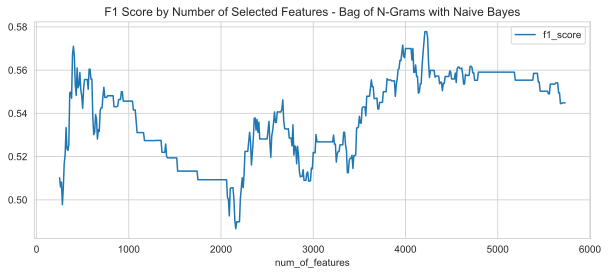

In [45]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Bag of N-Grams with Naive Bayes", figsize=(10, 4))

In [46]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
acc_df.sort_values(by='f1_score', ascending=False).head(5)

4180 4280 1


,num_of_features,f1_score,accuracy
398,4230,0.58,0.59
396,4210,0.58,0.59
397,4220,0.58,0.59
399,4240,0.58,0.58
395,4200,0.57,0.58


#### Get a more fine-grained look at the optimal number of features region

In [47]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_nb_bong, i, X_train_bong, y_train, X_test_bong, y_test)
    rows.append([i, f1_i, accuracy_i])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

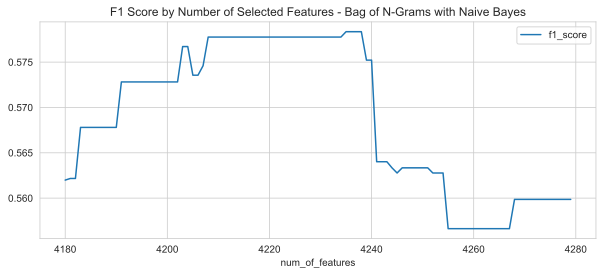

In [48]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Bag of N-Grams with Naive Bayes", figsize=(10, 4))

In [49]:
acc_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
58,4238,0.58,0.59
57,4237,0.58,0.59
56,4236,0.58,0.59
55,4235,0.58,0.59
50,4230,0.58,0.59


## Benchmark Bag of N-Grams With Optimal Features Selected using Naive Bayes Model

In [50]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat

4238

In [51]:
model_nb_bong_opt = MultinomialNB()
cm_optimal, pred_opt, f1_opt, report_opt, accuracy_opt = SelectBestModelFeatures_Chi(model_nb_bong_opt, Opt_no_of_feat, X_train_bong, y_train, X_test_bong, y_test)

In [52]:
print(report_opt)

precision    recall  f1-score   support

auto-repair-appt-1       1.00      0.89      0.94        18
 coffee-ordering-1       0.60      0.32      0.41        19
 coffee-ordering-2       0.43      0.62      0.51        16
      movie-finder       1.00      0.64      0.78        11
   movie-tickets-1       0.65      0.85      0.74        20
   movie-tickets-2       0.57      0.55      0.56        22
   movie-tickets-3       0.73      0.67      0.70        24
  pizza-ordering-1       0.00      0.00      0.00        14
  pizza-ordering-2       0.52      0.65      0.58        23
restaurant-table-1       0.75      0.27      0.40        22
restaurant-table-2       0.42      0.82      0.56        17
restaurant-table-3       0.67      0.62      0.65        16
       uber-lyft-1       0.73      0.53      0.62        15
       uber-lyft-2       0.53      0.77      0.62        13

          accuracy                           0.59       250
         macro avg       0.61      0.59      0.58       25

In [53]:
# Save benchmark output
rows_benchmarks.append(["Bag of N-Gram Naive Bayes Optimal Features Selected: 960", f1_opt, accuracy_opt])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.63,0.64
1,BOW Naive Bayes Optimal Features Selected: 1110,0.73,0.73
2,Bag of N-Gram Naive Bayes All Features,0.58,0.59
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.58,0.59


## TF-IDF Feature Extraction

In [54]:
#from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)
#vocab_tfidf = count_vect.vocabulary_
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(750, 4913)
(250, 4913)


## TF-IDF Baseline Benchmarking with Naive Bayes Classifier: Multinomial variant

In [55]:
clf = MultinomialNB()#.fit(X_train_tfidf, y_train)

cm_nb_tfidf, pred_nb_tfidf, f1_nb_tfidf, report_nb_tfidf, accuracy_nb_tfidf = Build_Model(clf, X_train_tfidf, y_train, X_test_tfidf, y_test)

#### Make Some Predictions

In [56]:
X_new_data_counts = count_vect.transform(["appointment online car checking bmw okay hold minute problem okay entered thank need bring need alignment"])
X_new_data_tfidf = tfidf_transformer.fit_transform(X_new_data_counts)
print(X_new_data_tfidf.shape)
y_pred_new = clf.predict(X_new_data_tfidf)
y_pred_new

(1, 4913)


array(['auto-repair-appt-1'], dtype='<U18')

#### Metrics for TF-IDF with Naive Bayes Classifier: Multinomial variant

In [57]:
from sklearn.metrics import confusion_matrix

cm_nb_tfidf

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 19, 15,  1,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1, 20,  6,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  0, 15,  8,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  7,  0,  1, 14,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  4,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 11, 19,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  1,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0, 20, 16, 13,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  6],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  7]],
      dtype=int64)

In [58]:
from sklearn import metrics

print("Label" + report_nb_tfidf)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.00      0.00      0.00        19
 coffee-ordering-2       0.41      0.94      0.57        16
      movie-finder       0.00      0.00      0.00        11
   movie-tickets-1       0.69      1.00      0.82        20
   movie-tickets-2       0.60      0.68      0.64        22
   movie-tickets-3       0.64      0.58      0.61        24
  pizza-ordering-1       0.20      0.07      0.11        14
  pizza-ordering-2       0.63      0.83      0.72        23
restaurant-table-1       0.67      0.09      0.16        22
restaurant-table-2       0.32      0.94      0.48        17
restaurant-table-3       1.00      0.19      0.32        16
       uber-lyft-1       0.60      0.60      0.60        15
       uber-lyft-2       0.54      0.54      0.54        13

          accuracy                           0.56       250
         macro avg       0.52    

In [59]:
# Save benchmark output
rows_benchmarks.append(["TF-IDF Naive Bayes All Features", f1_nb_tfidf, accuracy_nb_tfidf])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.63,0.64
1,BOW Naive Bayes Optimal Features Selected: 1110,0.73,0.73
2,Bag of N-Gram Naive Bayes All Features,0.58,0.59
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.58,0.59
4,TF-IDF Naive Bayes All Features,0.49,0.56


In [60]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

def SelectBestModelFeatures_Chi_sparse(model, num_feats, features_train, labels_train, features_test, labels_test):
    X_norm = MaxAbsScaler().fit_transform(features_train, labels_train)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, labels_train)
    chi_support = chi_selector.get_support()
    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]
    classifier_chi = model.fit(X_train_chi, labels_train)

    # Predicter to output
    predict_chi = classifier_chi.predict(X_test_chi)

    # Metrics to output
    cm_chi = confusion_matrix(predict_chi,labels_test)
    report_chi = metrics.classification_report(labels_test, predict_chi)
    f1_chi = metrics.f1_score(labels_test, predict_chi, average='weighted')
    accuracy_chi = cm_chi.trace()/cm_chi.sum()

    return cm_chi, predict_chi, f1_chi, report_chi, accuracy_chi

## Feature Selection - TF-IDF with Naive Bayes

In [61]:
rows = []
for i in range(50, 4850, 100): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi_sparse(clf, i, X_train_tfidf, y_train, X_test_tfidf, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_tfidf_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

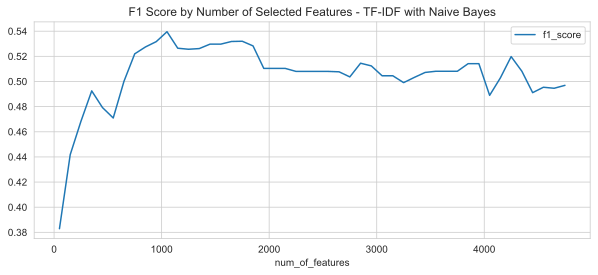

In [62]:
sel_nb_tfidf_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - TF-IDF with Naive Bayes", figsize=(10, 4))

In [63]:
Opt_no_of_feat = int(sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).head(5)

1000 1100 1


,num_of_features,f1_score,accuracy
10,1050,0.54,0.59
17,1750,0.53,0.58
16,1650,0.53,0.58
9,950,0.53,0.58
15,1550,0.53,0.58


#### Take closer look at region around optimal features

In [64]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi_sparse(clf, i, X_train_tfidf, y_train, X_test_tfidf, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_tfidf_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

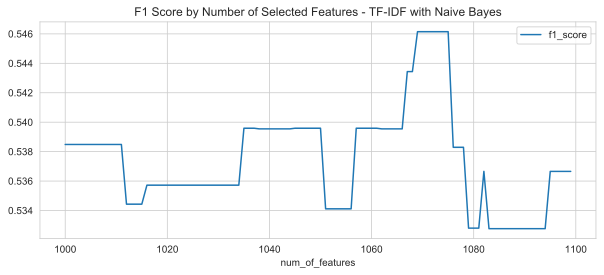

In [65]:
sel_nb_tfidf_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - TF-IDF with Naive Bayes", figsize=(10, 4))

In [66]:
Opt_no_of_feat = int(sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
75,1075,0.55,0.60
74,1074,0.55,0.60
73,1073,0.55,0.60
72,1072,0.55,0.60
71,1071,0.55,0.60


## Benchmark TF-IDF Features with Naive Bayes on Optimal Features

In [67]:
cm_tf_nb, pred_tf_nb, f1_tf_nb, report_tf_nb, accuracy_tf_nb = SelectBestModelFeatures_Chi_sparse(clf, Opt_no_of_feat, X_train_tfidf, y_train, X_test_tfidf, y_test)
# Save benchmark output
rows_benchmarks.append(["TF-IDF Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), f1_tf_nb, accuracy_tf_nb])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.63,0.64
1,BOW Naive Bayes Optimal Features Selected: 1110,0.73,0.73
2,Bag of N-Gram Naive Bayes All Features,0.58,0.59
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.58,0.59
4,TF-IDF Naive Bayes All Features,0.49,0.56
5,TF-IDF Naive Bayes Optimal Features Selected: 1075,0.55,0.60


#### Metrics For Each Class

In [68]:
from sklearn import metrics
print("Label" + report_tf_nb)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       1.00      0.05      0.10        19
 coffee-ordering-2       0.43      0.94      0.59        16
      movie-finder       1.00      0.18      0.31        11
   movie-tickets-1       0.67      1.00      0.80        20
   movie-tickets-2       0.65      0.68      0.67        22
   movie-tickets-3       0.64      0.58      0.61        24
  pizza-ordering-1       0.33      0.14      0.20        14
  pizza-ordering-2       0.66      0.83      0.73        23
restaurant-table-1       0.67      0.09      0.16        22
restaurant-table-2       0.33      0.94      0.49        17
restaurant-table-3       0.80      0.25      0.38        16
       uber-lyft-1       0.83      0.67      0.74        15
       uber-lyft-2       0.69      0.85      0.76        13

          accuracy                           0.60       250
         macro avg       0.69    

## Word2Vec Feature Extraction

In [69]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['pizza', 'terminator', 'star', 'east', 'korean','playing']}
similar_words

{'pizza': ['sausage', 'large', 'topping', 'bacon', 'jack'],
 'terminator': ['abyss', 'judgment', 'avatar', 'sigourney', 'weaver'],
 'star': ['wars', 'jedi', 'runner', 'blade', 'iv'],
 'east': ['enjoyed', 'lower', 'uptown', 'stadium', 'siri'],
 'korean': ['lauderhill', 'bbgo', 'pig', 'germantown', 'pinellas'],
 'playing': ['pet', 'times', 'ocala', 'hell', 'uptown']}

#### Visualizing word embeddings

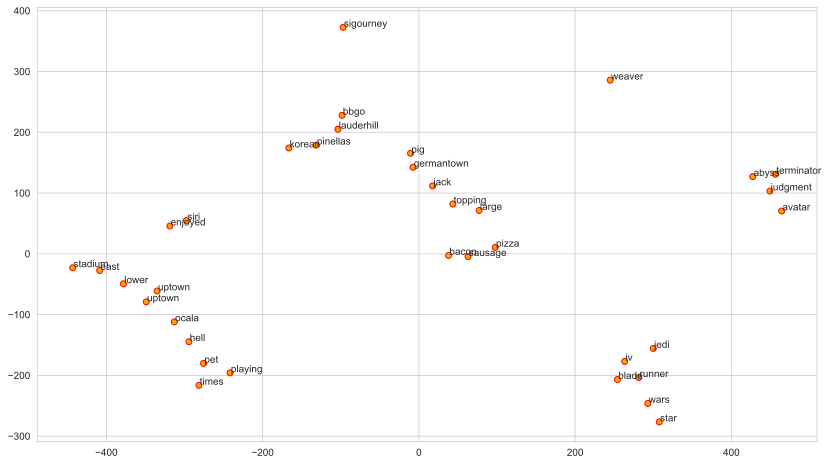

In [70]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

#### Applying the word2vec model on our Train dataset

In [71]:
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]
tokenized_corpus_test = [wpt.tokenize(document) for document in X_test]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)

In [72]:
def Get_W2V_Model(feat_size):
    w2v_mod = word2vec.Word2Vec(tokenized_corpus, size=feat_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)
    return w2v_mod

#### Do a Word Test

In [73]:
w2v_model.wv['jedi']

array([-0.32215646, -0.25536215,  0.28881735,  0.37460986, -0.1785209 ,
        0.15640481, -0.24927685,  0.45267016, -0.11916102,  0.09655154,
       -0.01096867, -0.04109757, -0.14419763, -0.27617273,  0.3699495 ,
        0.70794743, -0.89402825,  0.7922779 , -0.05307756,  0.591101  ,
        0.26935577, -0.51421994, -0.18169962,  0.49699754,  0.18158895,
        0.8309414 , -0.1788033 ,  0.30659837, -0.0174735 , -0.10513857,
       -0.0435609 ,  0.3113637 , -0.22355027, -0.41728494, -0.08063657,
       -0.44692856,  0.27115574,  0.10438384, -0.54383045, -0.6677722 ,
        0.20307443, -0.7444285 , -0.6824159 , -0.14899632,  0.2717918 ,
        0.30334166, -0.643413  , -0.10315035, -0.25229535, -0.16166411,
        0.71972525,  0.21391109, -0.17943202, -0.12783799, -0.23111914,
       -0.56914175, -0.8249163 , -0.3141917 ,  0.2863672 , -0.16364092,
        0.18841425,  0.51483166,  0.12446295, -0.5553186 ,  0.43252727,
       -0.29227576, -0.33111745,  0.07952029, -0.28381705,  0.03

#### Build framework for getting document level embeddings

In [74]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [75]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-0.45,-0.83,-0.52,-0.02,0.66,0.08,-0.98,-0.58,-0.65,-0.02,1.09,-0.45,0.43,-0.19,-0.46,...,0.95,0.28,0.35,-0.76,0.22,0.25,0.25,0.15,-0.70,0.42,0.07,-0.40,0.76,0.38,-0.06
1,0.26,-0.27,0.53,0.92,-0.06,0.03,1.00,0.49,0.33,0.28,0.30,-0.32,-0.12,0.32,-0.58,...,-0.15,-0.20,-0.48,0.15,-0.75,1.07,0.39,-0.96,0.60,0.17,0.21,0.39,0.50,0.23,-0.41
2,-0.47,0.21,-0.33,-0.58,0.64,-0.60,-0.51,-0.01,0.50,-0.06,0.82,0.03,0.21,0.92,0.82,...,-0.66,-0.71,0.53,-0.20,0.54,0.19,-0.64,-0.52,0.92,-0.31,-0.43,0.24,-0.75,0.57,-0.02
3,-1.32,-1.03,-0.96,0.61,0.02,1.15,-0.24,-0.50,-0.31,0.74,0.16,0.96,-0.06,0.08,-0.95,...,-0.60,-0.75,1.01,0.01,0.67,-0.51,0.06,-0.70,0.32,-0.29,1.18,0.93,-0.66,-0.07,0.30
4,-0.59,-1.01,-0.25,0.05,0.64,0.18,-0.60,-0.45,-0.37,-0.09,1.12,-0.31,0.49,0.13,-0.58,...,-0.12,-0.81,0.33,-0.57,0.80,0.14,0.31,-0.42,0.46,0.12,0.62,-0.04,-0.05,0.65,-0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,-0.21,0.16,0.20,-0.10,-0.02,0.12,-0.47,0.26,0.22,-0.41,0.72,-0.31,0.03,0.67,0.31,...,-0.02,-0.39,0.25,-0.18,0.17,0.45,0.14,-0.83,0.71,0.27,-0.09,-0.09,-0.06,0.52,0.26
746,-0.55,-0.40,0.77,0.53,0.33,0.44,1.22,-0.95,-0.69,-0.19,0.22,-0.19,0.66,0.13,-1.89,...,0.03,0.33,1.12,0.79,1.10,-0.72,0.02,0.63,-0.79,0.25,0.42,-0.09,-0.01,0.52,0.53
747,-0.34,-0.53,0.30,-0.35,0.20,-0.03,-0.04,-0.42,0.25,-0.19,0.93,-0.47,0.38,0.37,0.67,...,0.06,-0.18,0.13,-0.27,0.43,0.30,-0.24,-0.45,0.83,0.18,0.15,-0.09,0.04,0.38,-0.21
748,-0.43,-0.73,-0.66,0.21,0.21,0.21,0.05,-0.66,-0.21,0.53,0.70,-0.33,0.76,0.41,-0.96,...,-0.62,-0.61,-0.29,-0.19,-0.03,0.31,0.45,-0.57,0.36,0.03,0.70,0.33,0.12,0.66,-0.69


In [76]:
w2v_test_array = averaged_word_vectorizer(corpus=tokenized_corpus_test, model=w2v_model,
                                             num_features=feature_size)
                                             
print(w2v_test_array.shape)

(250, 100)


## Word2vec Feature Benchmarking with Naive Bayes Classifier

In [77]:
from sklearn.naive_bayes import GaussianNB

#model_w2v_nb = MultinomialNB()
model_w2v_nb = GaussianNB()
cm_nb_w2v, pred_nb_w2v, f1_nb_w2v, report_nb_w2v, accuracy_nb_w2v  = SelectBestModelFeatures_Chi(model_w2v_nb, 100, w2v_feature_array, y_train, w2v_test_array, y_test)
# Save benchmark output
rows_benchmarks.append(["Word2Vec Naive Bayes All Features", f1_nb_w2v, accuracy_nb_w2v])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.63,0.64
1,BOW Naive Bayes Optimal Features Selected: 1110,0.73,0.73
2,Bag of N-Gram Naive Bayes All Features,0.58,0.59
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.58,0.59
4,TF-IDF Naive Bayes All Features,0.49,0.56
5,TF-IDF Naive Bayes Optimal Features Selected: 1075,0.55,0.60
6,Word2Vec Naive Bayes All Features,0.61,0.60


In [78]:
cm_nb_w2v

array([[16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  7,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 11,  8,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 14,  6,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  6, 13,  5,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  3, 18,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  5,  9,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  7, 14,  0,  0,  0,  0,  0],
       [ 1,  0,  1,  0,  0,  0,  0,  0,  0, 13,  1,  3,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  7,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  9, 11,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  4],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  9]],
      dtype=int64)

In [79]:
print("Label" + report_nb_w2v)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      0.89      0.94        18
 coffee-ordering-1       0.50      0.37      0.42        19
 coffee-ordering-2       0.38      0.50      0.43        16
      movie-finder       1.00      0.91      0.95        11
   movie-tickets-1       0.67      0.70      0.68        20
   movie-tickets-2       0.52      0.59      0.55        22
   movie-tickets-3       0.86      0.75      0.80        24
  pizza-ordering-1       0.33      0.36      0.34        14
  pizza-ordering-2       0.67      0.61      0.64        23
restaurant-table-1       0.65      0.59      0.62        22
restaurant-table-2       0.54      0.41      0.47        17
restaurant-table-3       0.44      0.69      0.54        16
       uber-lyft-1       0.60      0.40      0.48        15
       uber-lyft-2       0.50      0.69      0.58        13

          accuracy                           0.60       250
         macro avg       0.62    

## Feature Selection - Word2Vec Features with Naive Bayes Model

In [80]:
rows = []
for i in range(1, 100, 1): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_w2v_nb, i, w2v_feature_array, y_train, w2v_test_array, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_w2v_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

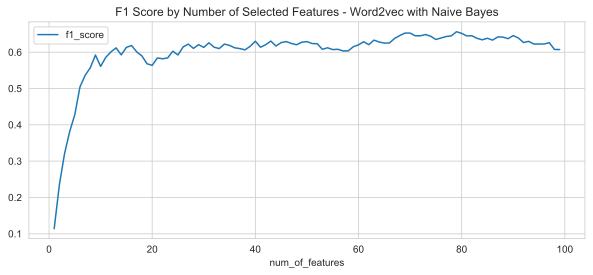

In [81]:
sel_nb_w2v_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Word2vec with Naive Bayes", figsize=(10, 4))

In [82]:
Opt_no_of_feat = int(sel_nb_w2v_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_w2v_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
78,79,0.66,0.66
69,70,0.65,0.65
68,69,0.65,0.65
79,80,0.65,0.65
72,73,0.65,0.65


In [83]:
cm_nb_w2v, pred_nb_w2v, f1_nb_w2v, report_nb_w2v, accuracy_nb_w2v  = SelectBestModelFeatures_Chi(model_w2v_nb, Opt_no_of_feat, w2v_feature_array, y_train, w2v_test_array, y_test)
# Save benchmark output
rows_benchmarks.append(["Word2Vec Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), f1_nb_w2v, accuracy_nb_w2v])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.63,0.64
1,BOW Naive Bayes Optimal Features Selected: 1110,0.73,0.73
2,Bag of N-Gram Naive Bayes All Features,0.58,0.59
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.58,0.59
4,TF-IDF Naive Bayes All Features,0.49,0.56
5,TF-IDF Naive Bayes Optimal Features Selected: 1075,0.55,0.60
6,Word2Vec Naive Bayes All Features,0.61,0.60
7,Word2Vec Naive Bayes Optimal Features Selected: 79,0.66,0.66


## Word2vec features Extraction with Fastext Model

In [84]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words


ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1, iter=50)

In [85]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['rental', 'pizza', 'terminator', 'star', 'audi', 'east', 'korean','playing']}
similar_words

{'rental': ['let', 'looking', 'well', 'sure', 'time'],
 'pizza': ['pepperoni', 'cheese', 'pizzas', 'toppings', 'large'],
 'terminator': ['terminal', 'jfk', 'airport', 'traffic', 'linda'],
 'star': ['recommendations', 'wars', 'something', 'episode', 'recommended'],
 'audi': ['popcorn', 'watched', 'austin', 'texas', 'visa'],
 'east': ['broccoli', 'pies', 'late', 'nine', 'well'],
 'korean': ['bbq', 'reservations', 'p', 'grill', 'alex'],
 'playing': ['movie', 'see', 'theater', 'tickets', 'showing']}

#### PCA on Fasttext Model

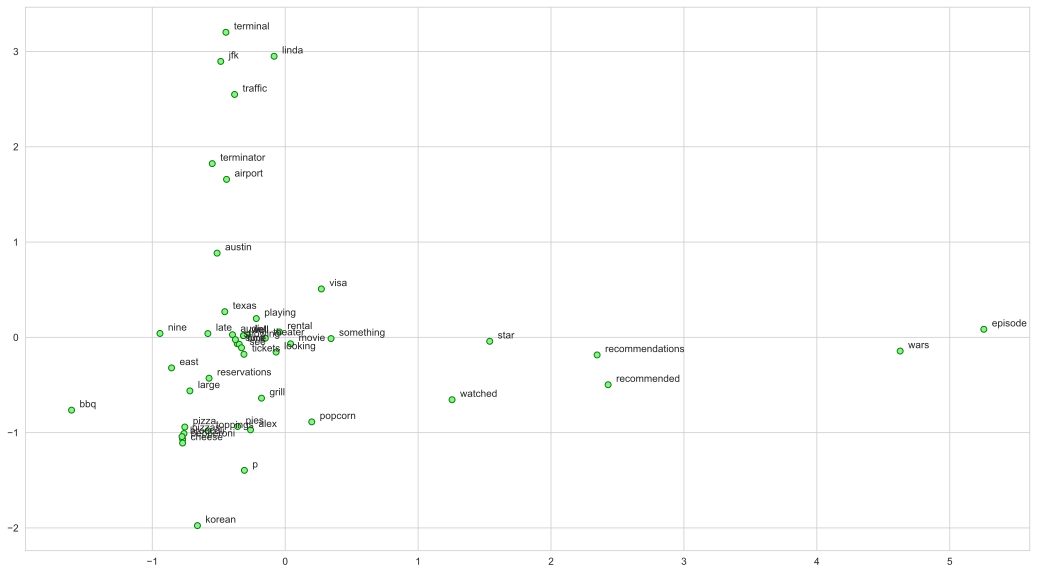

In [86]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [87]:
print(P.shape)

(48, 2)


In [88]:
ft_model.wv['rental']

array([ 0.14320092, -0.08772472, -0.21409072, -0.3321557 ,  0.16198756,
       -0.09128235,  0.45122248,  0.17695946, -0.28787157,  0.06355111,
        0.07830023, -0.1941516 ,  0.17160933, -0.20840687,  0.31993073,
       -0.06575908, -0.30635872,  0.04672587,  0.14248927, -0.18184376,
        0.06738096, -0.31776607,  0.40318805, -0.13934949, -0.10835174,
       -0.12004109, -0.21035695,  0.24591494, -0.01685474, -0.29699358,
       -0.19467358,  0.0593622 ,  0.15167359, -0.14583743,  0.17052136,
       -0.08372065, -0.06083521, -0.06975104, -0.5557205 , -0.1186133 ,
        0.05043286,  0.051803  ,  0.10414893,  0.28178173, -0.09327526,
        0.11997101, -0.0699309 ,  0.24233079,  0.01482999,  0.0285987 ,
       -0.17278029, -0.2754742 , -0.34433228,  0.3585826 ,  0.28904635,
        0.05464154, -0.2892611 , -0.02134229,  0.13393575, -0.01384271,
       -0.14892377,  0.01929763,  0.02553422, -0.18757913, -0.21825944,
       -0.19049186,  0.18194774, -0.3671299 ,  0.14955613,  0.04

In [89]:
print(ft_model.wv.similarity(w1='pizza', w2='born'))
print(ft_model.wv.similarity(w1='playing', w2='movie'))

0.22585046
0.7491547


In [90]:
st1 = "'tickets movie showing john"
print('Odd one out for [',st1, ']:', ft_model.wv.doesnt_match(st1.split()))

st2 = "pepperoni pizzas cheese pies"
print('Odd one out for [',st2, ']:', ft_model.wv.doesnt_match(st2.split()))

Odd one out for [ 'tickets movie showing john ]: 'tickets
Odd one out for [ pepperoni pizzas cheese pies ]: pies


## WOrd2Vec Features from Fastext Benchmarking with Naive Bayes Model

In [91]:
w2v_ft_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=ft_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-0.45,-0.83,-0.52,-0.02,0.66,0.08,-0.98,-0.58,-0.65,-0.02,1.09,-0.45,0.43,-0.19,-0.46,...,0.95,0.28,0.35,-0.76,0.22,0.25,0.25,0.15,-0.70,0.42,0.07,-0.40,0.76,0.38,-0.06
1,0.26,-0.27,0.53,0.92,-0.06,0.03,1.00,0.49,0.33,0.28,0.30,-0.32,-0.12,0.32,-0.58,...,-0.15,-0.20,-0.48,0.15,-0.75,1.07,0.39,-0.96,0.60,0.17,0.21,0.39,0.50,0.23,-0.41
2,-0.47,0.21,-0.33,-0.58,0.64,-0.60,-0.51,-0.01,0.50,-0.06,0.82,0.03,0.21,0.92,0.82,...,-0.66,-0.71,0.53,-0.20,0.54,0.19,-0.64,-0.52,0.92,-0.31,-0.43,0.24,-0.75,0.57,-0.02
3,-1.32,-1.03,-0.96,0.61,0.02,1.15,-0.24,-0.50,-0.31,0.74,0.16,0.96,-0.06,0.08,-0.95,...,-0.60,-0.75,1.01,0.01,0.67,-0.51,0.06,-0.70,0.32,-0.29,1.18,0.93,-0.66,-0.07,0.30
4,-0.59,-1.01,-0.25,0.05,0.64,0.18,-0.60,-0.45,-0.37,-0.09,1.12,-0.31,0.49,0.13,-0.58,...,-0.12,-0.81,0.33,-0.57,0.80,0.14,0.31,-0.42,0.46,0.12,0.62,-0.04,-0.05,0.65,-0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,-0.21,0.16,0.20,-0.10,-0.02,0.12,-0.47,0.26,0.22,-0.41,0.72,-0.31,0.03,0.67,0.31,...,-0.02,-0.39,0.25,-0.18,0.17,0.45,0.14,-0.83,0.71,0.27,-0.09,-0.09,-0.06,0.52,0.26
746,-0.55,-0.40,0.77,0.53,0.33,0.44,1.22,-0.95,-0.69,-0.19,0.22,-0.19,0.66,0.13,-1.89,...,0.03,0.33,1.12,0.79,1.10,-0.72,0.02,0.63,-0.79,0.25,0.42,-0.09,-0.01,0.52,0.53
747,-0.34,-0.53,0.30,-0.35,0.20,-0.03,-0.04,-0.42,0.25,-0.19,0.93,-0.47,0.38,0.37,0.67,...,0.06,-0.18,0.13,-0.27,0.43,0.30,-0.24,-0.45,0.83,0.18,0.15,-0.09,0.04,0.38,-0.21
748,-0.43,-0.73,-0.66,0.21,0.21,0.21,0.05,-0.66,-0.21,0.53,0.70,-0.33,0.76,0.41,-0.96,...,-0.62,-0.61,-0.29,-0.19,-0.03,0.31,0.45,-0.57,0.36,0.03,0.70,0.33,0.12,0.66,-0.69


In [92]:
w2v_ft_test_array = averaged_word_vectorizer(corpus=tokenized_corpus_test, model=ft_model,
                                             num_features=feature_size)

In [93]:
model_ft_nb = GaussianNB()
cm_nb_ft, pred_nb_ft, f1_nb_ft, report_nb_ft, accuracy_nb_ft  = SelectBestModelFeatures_Chi(model_ft_nb, 100, w2v_ft_feature_array, y_train, w2v_ft_test_array, y_test)
# Save benchmark output
rows_benchmarks.append(["Word2Vec Fastext Naive Bayes All Features", f1_nb_ft, accuracy_nb_ft])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.63,0.64
1,BOW Naive Bayes Optimal Features Selected: 1110,0.73,0.73
2,Bag of N-Gram Naive Bayes All Features,0.58,0.59
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.58,0.59
4,TF-IDF Naive Bayes All Features,0.49,0.56
5,TF-IDF Naive Bayes Optimal Features Selected: 1075,0.55,0.60
6,Word2Vec Naive Bayes All Features,0.61,0.60
7,Word2Vec Naive Bayes Optimal Features Selected: 79,0.66,0.66
8,Word2Vec Fastext Naive Bayes All Features,0.56,0.60


## Word2Vec from Fastext Model Feature Selction with Naive Bayes Model

In [94]:
rows = []
for i in range(1, 100, 1): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_ft_nb, i, w2v_ft_feature_array, y_train, w2v_ft_test_array, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_ft_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

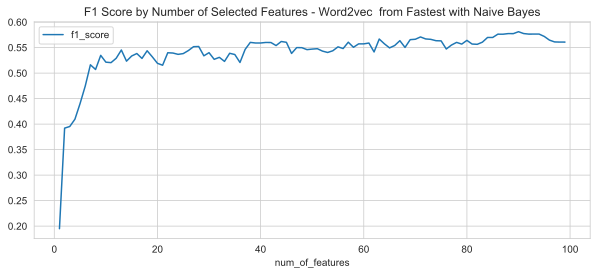

In [95]:
sel_nb_ft_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Word2vec  from Fastest with Naive Bayes", figsize=(10, 4))

In [96]:
Opt_no_of_feat = int(sel_nb_ft_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_ft_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
89,90,0.58,0.61
90,91,0.58,0.61
87,88,0.58,0.61
88,89,0.58,0.61
92,93,0.58,0.61


## Benchmarking Word2Vec Fastext with Naive Bayes on Optimal number of Features

In [97]:
cm_nb_ft, pred_nb_ft, f1_nb_ft, report_nb_ft, accuracy_nb_ft  = SelectBestModelFeatures_Chi(model_ft_nb, Opt_no_of_feat, w2v_ft_feature_array, y_train, w2v_ft_test_array, y_test)
# Save benchmark output
rows_benchmarks.append(["Word2Vec from Fastest Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), f1_nb_ft, accuracy_nb_ft])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.63,0.64
1,BOW Naive Bayes Optimal Features Selected: 1110,0.73,0.73
2,Bag of N-Gram Naive Bayes All Features,0.58,0.59
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.58,0.59
4,TF-IDF Naive Bayes All Features,0.49,0.56
5,TF-IDF Naive Bayes Optimal Features Selected: 1075,0.55,0.60
6,Word2Vec Naive Bayes All Features,0.61,0.60
7,Word2Vec Naive Bayes Optimal Features Selected: 79,0.66,0.66
8,Word2Vec Fastext Naive Bayes All Features,0.56,0.60
9,Word2Vec from Fastest Naive Bayes Optimal Features Selected: 90,0.58,0.61


## Feature Extraction: Glove Word Embeddings

#### GloVe Embeddings with spaCy

In [98]:
import spacy

nlp = spacy.load('en_vectors_web_lg')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 1070971


#### Visualize GloVe word embeddings

In [99]:
unique_words = list(set([word for sublist in [doc.split() for doc in X_train] for word in sublist]))
word_glove_vectors = np.array([nlp(word).vector for word in unique_words])

pd.DataFrame(word_glove_vectors, index=unique_words)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
score,-0.42,0.69,-0.06,0.01,-0.07,-0.49,-0.18,-0.02,0.81,1.82,0.16,0.56,-0.21,0.28,0.09,...,0.13,0.07,-0.71,0.37,0.22,-0.09,0.03,0.25,0.61,0.68,0.07,-0.07,-0.03,0.39,-0.17
specialty,0.11,-0.14,0.32,-0.35,0.84,-0.17,-0.20,0.05,-0.38,1.67,-0.37,0.05,0.11,-0.56,0.22,...,0.30,-0.04,0.39,-0.49,0.32,0.07,-0.24,-0.57,-0.08,-0.81,-0.72,0.09,-0.47,0.64,0.24
indie,0.56,-0.07,-0.22,0.43,0.65,-0.14,-0.06,-0.91,0.03,1.14,-0.20,0.00,-0.12,-0.02,0.28,...,0.19,-0.00,-0.99,-0.14,-0.19,-1.00,0.17,0.24,0.68,-0.12,-0.17,0.61,0.01,-0.39,0.19
interests,0.03,-0.34,-0.03,-0.06,-0.21,-0.04,-0.49,0.13,-0.15,3.18,-0.79,0.11,0.04,0.04,0.05,...,0.36,0.20,0.41,-0.06,0.08,-0.46,-0.08,-0.26,-0.40,0.61,0.09,0.11,-0.61,-0.01,0.21
frapac,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
luggage,0.11,0.18,0.04,-0.05,0.58,0.65,-0.39,-0.69,-0.27,1.11,0.02,-0.30,0.13,0.42,-0.33,...,-0.14,0.12,0.23,0.26,0.22,-0.46,-0.36,0.84,-0.52,0.65,-0.16,0.64,0.49,0.05,-0.16
ohlets,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
seth,-0.57,0.53,0.33,0.44,-0.36,0.03,0.38,-0.83,0.18,-0.18,-0.26,-0.88,-0.15,0.00,0.00,...,-0.14,0.54,0.30,0.35,0.03,0.42,-0.22,-0.46,0.32,0.18,-0.38,-0.29,0.31,-0.50,0.14
hilside,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [100]:
unique_words_test = list(set([word for sublist in [doc.split() for doc in X_test] for word in sublist]))
word_glove_vectors_test = np.array([nlp(word).vector for word in unique_words])
print(word_glove_vectors_test.shape)

(4931, 300)


#### GloVe Embeddings with Flair

In [101]:
from flair.embeddings import WordEmbeddings, DocumentRNNEmbeddings

glove_embedding = WordEmbeddings('glove')
document_embeddings = DocumentRNNEmbeddings([glove_embedding])

In [102]:
from flair.embeddings import Sentence

# create an example sentence
sentence = Sentence('The grass is green . And the sky is blue .')
# embed the sentence with our document embedding
document_embeddings.embed(sentence)
# now check out the embedded sentence.
print(sentence.get_embedding())

tensor([-0.2564, -0.1569, -0.5069,  0.1083,  0.3357, -0.1093, -0.1621, -0.2105,
        -0.0546, -0.0867,  0.1848, -0.1774, -0.0560,  0.1958,  0.1018, -0.1017,
        -0.1447, -0.1574, -0.1318, -0.0874,  0.4242, -0.3073,  0.3422,  0.2502,
        -0.4240, -0.3679,  0.0283,  0.1972, -0.2751, -0.0942, -0.2384,  0.2482,
         0.3544,  0.0052,  0.1816, -0.0354,  0.1334, -0.1680, -0.0747,  0.0847,
        -0.2236,  0.0713, -0.1707,  0.0834, -0.0433,  0.0523,  0.0872, -0.5142,
         0.3687,  0.0787,  0.2535, -0.0651, -0.0280,  0.1733,  0.1735, -0.1851,
        -0.2671,  0.1005,  0.2282, -0.1620,  0.2326,  0.2271,  0.2055,  0.3907,
         0.1336,  0.2996, -0.3332, -0.0860,  0.3025, -0.1836, -0.1523,  0.1104,
        -0.2395, -0.2861, -0.0396, -0.4666,  0.0298,  0.0116, -0.0313,  0.1162,
         0.1955, -0.1559, -0.3370,  0.5160, -0.2451,  0.3655, -0.0203, -0.6461,
         0.1019,  0.1314,  0.3092, -0.0732, -0.1104, -0.1455,  0.4197,  0.0288,
        -0.2243,  0.2406,  0.1209,  0.13

In [103]:
from nltk.tokenize import word_tokenize

def Get_Glove_Features(corpus):
    dataset_size = len(corpus)
    X = np.zeros((dataset_size, 128))
    for iter in range(0, dataset_size - 1):
        text = corpus[iter]
        sentence = Sentence(text)
        document_embeddings.embed(sentence)
        X[iter] = sentence.get_embedding().detach().numpy()
    return X

In [104]:
x_train_glove = Get_Glove_Features(X_train)
x_test_glove = Get_Glove_Features(X_test)
print(x_train_glove.shape, x_test_glove.shape)

(750, 128) (250, 128)


In [105]:
pd.DataFrame(x_train_glove)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,-0.49,-0.17,-0.49,0.13,0.28,-0.05,-0.09,-0.09,-0.33,-0.09,-0.01,-0.13,0.27,0.42,-0.04,...,0.08,-0.20,-0.07,-0.05,-0.43,0.20,-0.05,0.09,0.41,0.29,-0.05,0.16,-0.02,0.13,0.01
1,-0.54,-0.33,-0.16,-0.27,0.38,-0.17,0.01,-0.13,-0.34,0.03,0.17,-0.24,-0.11,0.30,0.10,...,0.12,0.12,0.11,-0.05,-0.42,-0.34,-0.10,0.17,0.31,-0.27,-0.01,0.17,-0.10,0.19,-0.08
2,-0.53,-0.18,-0.27,0.06,0.37,-0.01,-0.16,-0.23,-0.16,-0.32,0.14,-0.21,-0.07,0.21,0.49,...,0.36,-0.35,0.09,0.16,-0.09,-0.09,0.08,-0.14,0.17,-0.01,-0.33,-0.09,-0.23,-0.05,-0.11
3,-0.61,-0.04,-0.41,0.17,0.29,0.07,0.07,-0.09,-0.10,-0.32,0.14,-0.22,-0.13,0.41,0.29,...,0.09,-0.34,0.13,-0.15,-0.53,0.07,-0.05,0.04,0.20,0.04,-0.29,-0.04,-0.04,-0.02,-0.01
4,-0.24,-0.24,-0.02,-0.35,0.26,-0.29,-0.12,-0.14,-0.02,-0.13,-0.11,-0.09,0.11,0.19,0.36,...,0.27,0.13,0.01,-0.12,-0.12,-0.21,-0.26,0.05,0.23,-0.33,0.16,-0.12,-0.12,0.15,-0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,-0.37,-0.33,-0.15,-0.24,0.42,-0.34,-0.10,0.01,-0.17,-0.08,0.21,-0.00,0.18,0.16,0.11,...,-0.04,-0.08,-0.04,0.05,-0.43,-0.06,-0.12,0.16,0.33,-0.01,-0.04,0.14,-0.10,0.21,-0.01
746,-0.55,0.01,-0.27,-0.15,0.41,-0.20,0.06,-0.06,-0.21,-0.52,-0.10,-0.39,-0.04,0.27,0.36,...,0.05,-0.44,-0.25,0.12,-0.26,-0.11,-0.13,0.23,0.24,-0.12,-0.00,-0.18,-0.29,0.06,-0.12
747,-0.53,-0.28,-0.51,-0.04,0.33,-0.07,-0.10,-0.06,-0.11,-0.16,0.19,-0.24,0.17,0.38,0.24,...,0.12,-0.03,0.10,0.03,-0.51,-0.06,-0.14,0.10,0.34,-0.15,-0.16,0.11,0.11,0.11,-0.07
748,-0.32,-0.30,-0.37,-0.29,0.21,-0.25,-0.31,-0.12,-0.15,-0.05,-0.05,-0.11,0.08,0.37,0.26,...,0.10,0.05,-0.01,-0.12,-0.17,-0.11,-0.38,0.22,0.15,-0.32,0.08,-0.01,-0.28,0.25,0.04


In [106]:
model_glove_nb = GaussianNB()
cm_nb_glove, pred_nb_glove, f1_nb_glove, report_nb_glove, accuracy_nb_glove = Build_Model(model_glove_nb, x_train_glove, y_train, x_test_glove, y_test)
# Save benchmark output
# rows_benchmarks.append(["Glove with Naive Bayes All Features", f1_nb_glove, accuracy_nb_glove])
# df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
# df_benchmarks

## Feature Selection on Glove Features with Naive Bayes Model

In [107]:
rows = []
for i in range(1, 128, 1): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_glove_nb, i, x_train_glove, y_train, x_test_glove, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_glove_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

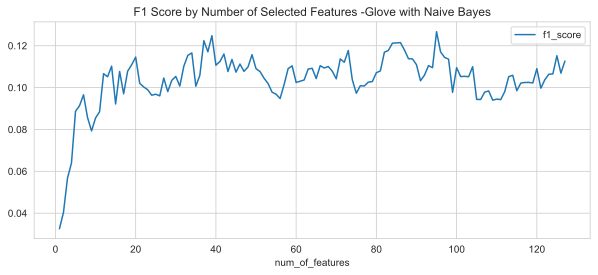

In [108]:
sel_nb_glove_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features -Glove with Naive Bayes", figsize=(10, 4))

In [109]:
Opt_no_of_feat = int(sel_nb_glove_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_glove_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
94,95,0.13,0.12
38,39,0.12,0.13
36,37,0.12,0.13
85,86,0.12,0.12
84,85,0.12,0.12


In [110]:
cm_nb_glove, pred_nb_glove, f1_nb_glove, report_nb_glove, accuracy_nb_glove  = SelectBestModelFeatures_Chi(model_glove_nb, Opt_no_of_feat, x_train_glove, y_train, x_test_glove, y_test)

# Save benchmark output
# rows_benchmarks.append(["Glove Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), f1_nb_glove, accuracy_nb_glove])
# df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
# df_benchmarks

In [111]:
# cm_nb_glove

In [112]:
# print("Label" + report_nb_glove)

#### Leave the Glove Feature result out for now since it clearly is problematic

## Combining Features

## Combine BOW and BAG of nGrams

In [113]:
def Get_Combined_Features(feat_1, feat_2):
    row_size = len(feat_1)
    col_size_1 = np.size(feat_1, axis=1)
    col_size = np.size(feat_1, axis=1) + np.size(feat_2, axis=1)
    X = np.zeros((row_size, col_size))
    #rint(X.shape, col_size_1, np.size(feat_2, axis=1), col_size)
    for i in range(0, row_size - 1):
        for j in range(0, col_size_1 - 1):
            X[i, j] = feat_1[i, j]

    for i in range(0, row_size - 1):
        for j in range(col_size_1, col_size - 1):
            X[i, j] = feat_2[i, j - col_size_1]
    return X

In [114]:
from numpy import column_stack

x_train_bow_bong = Get_Combined_Features(X_train_bow, X_train_bong)
x_test_bow_bong = Get_Combined_Features(X_test_bow, X_test_bong)

In [115]:
print(x_train_bow_bong.shape)
print(x_test_bow_bong.shape)

(750, 42403)
(250, 42403)


In [116]:
pd.DataFrame(x_test_bow_bong)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,42388,42389,42390,42391,42392,42393,42394,42395,42396,42397,42398,42399,42400,42401,42402
0,0.00,5.00,4.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,7.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,1.00,3.00,0.00,0.00,3.00,0.00,4.00,0.00,1.00,0.00,4.00,0.00,1.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,2.00,1.00,0.00,6.00,4.00,3.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,3.00,4.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,1.00,1.00,1.00,9.00,1.00,1.00,0.00,0.00,2.00,0.00,5.00,0.00,2.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.00,10.00,11.00,6.00,0.00,3.00,0.00,0.00,10.00,2.00,0.00,0.00,3.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
246,0.00,1.00,1.00,0.00,1.00,1.00,0.00,1.00,3.00,0.00,0.00,0.00,1.00,2.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
247,0.00,0.00,1.00,2.00,0.00,3.00,3.00,1.00,1.00,1.00,6.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
248,0.00,0.00,0.00,0.00,2.00,4.00,0.00,4.00,2.00,0.00,0.00,0.00,1.00,2.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [117]:
model_bow_bong = MultinomialNB()#.fit(X_train_tfidf, y_train)

cm_nb_bow_bong, pred_nb_bow_bong, f1_nb_bow_bong, report_bow_nb_bong, accuracy_bow_nb_bong = Build_Model(model_bow_bong, x_train_bow_bong, y_train, x_test_bow_bong, y_test)

In [118]:
print("Label" + report_bow_nb_bong)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      0.89      0.94        18
 coffee-ordering-1       1.00      0.11      0.19        19
 coffee-ordering-2       0.42      0.88      0.57        16
      movie-finder       1.00      0.64      0.78        11
   movie-tickets-1       0.67      0.80      0.73        20
   movie-tickets-2       0.45      0.68      0.55        22
   movie-tickets-3       0.80      0.50      0.62        24
  pizza-ordering-1       0.18      0.14      0.16        14
  pizza-ordering-2       0.60      0.65      0.63        23
restaurant-table-1       0.73      0.36      0.48        22
restaurant-table-2       0.34      0.82      0.48        17
restaurant-table-3       1.00      0.25      0.40        16
       uber-lyft-1       0.73      0.73      0.73        15
       uber-lyft-2       0.69      0.69      0.69        13

          accuracy                           0.58       250
         macro avg       0.69    

In [119]:
rows = []
for i in range(1000, 43000, 1000): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_bow_bong, i, x_train_bow_bong, y_train, x_test_bow_bong, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb__bow_bong_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

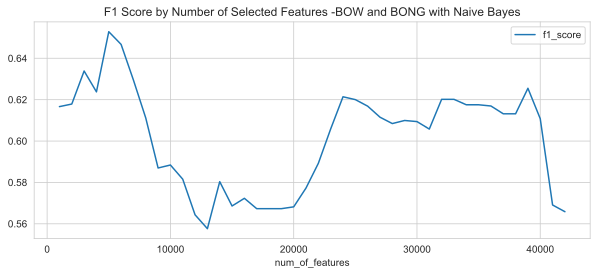

In [120]:
sel_nb__bow_bong_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features -BOW and BONG with Naive Bayes", figsize=(10, 4))

In [123]:
Opt_no_of_feat = int(sel_nb__bow_bong_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
sel_nb__bow_bong_df.sort_values(by='f1_score', ascending=False).head(5)

4950 5050 1


,num_of_features,f1_score,accuracy
4,5000,0.65,0.66
5,6000,0.65,0.65
2,3000,0.63,0.64
6,7000,0.63,0.64
38,39000,0.63,0.63


In [124]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_bow_bong, Opt_no_of_feat, x_train_bow_bong, y_train, x_test_bow_bong, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb__bow_bong_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

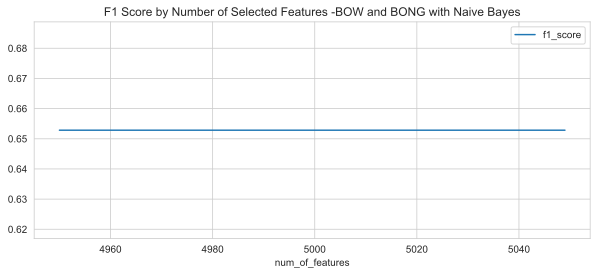

In [125]:
sel_nb__bow_bong_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features -BOW and BONG with Naive Bayes", figsize=(10, 4))

In [126]:
# Save benchmark output
rows_benchmarks.append(["BOW + Bag of NGrams Top: " + str(Opt_no_of_feat) + " Features with Naive Bayes", f1_i, accuracy_i])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.63,0.64
1,BOW Naive Bayes Optimal Features Selected: 1110,0.73,0.73
2,Bag of N-Gram Naive Bayes All Features,0.58,0.59
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.58,0.59
4,TF-IDF Naive Bayes All Features,0.49,0.56
5,TF-IDF Naive Bayes Optimal Features Selected: 1075,0.55,0.60
6,Word2Vec Naive Bayes All Features,0.61,0.60
7,Word2Vec Naive Bayes Optimal Features Selected: 79,0.66,0.66
8,Word2Vec Fastext Naive Bayes All Features,0.56,0.60
9,Word2Vec from Fastest Naive Bayes Optimal Features Selected: 90,0.58,0.61


## Try PCA Feature Extraction on the BOW Model 

In [128]:
from sklearn.decomposition import PCA

# Define PCA Selection Function
def SelectBestModelFeatures_PCA(model, i,  X_train_pca, y_train_pca, X_test_pca, y_test_pca):
    pca = PCA(n_components=i)
    fit = pca.fit(X_train_pca, y_train_pca)
    ftr_train = fit.transform(X_train_pca)
    ftr_test = fit.transform(X_test_pca)
    #model = GaussianNB()
    cm_nb_pca, pred_nb_pca, f1_nb_pca, report_nb_pca, accuracy_nb_pca = Build_Model(model, ftr_train, y_train, ftr_test, y_test)
    return cm_nb_pca, pred_nb_pca, f1_nb_pca, report_nb_pca, accuracy_nb_pca

In [129]:
# Loop through different no. of component values
model_nb_bow = GaussianNB()
rows = []
for i in range(5, 50, 1): # range(a, b, c) will count from a to b by intervals of c.
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_PCA(model_nb_bow, i,  X_train_bow, y_train, X_test_bow, y_test)
    rows.append([i, f1_i, accuracy_i])
acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

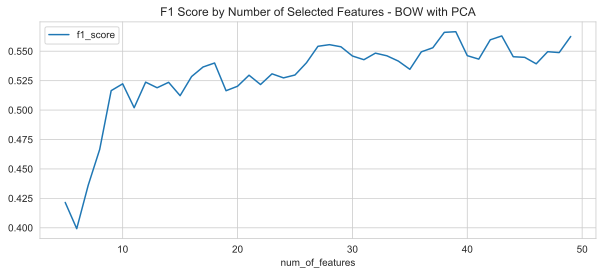

In [130]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with PCA", figsize=(10, 4))

In [131]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
print(Opt_no_of_feat)
acc_df.sort_values(by='f1_score', ascending=False).head(5)

39


,num_of_features,f1_score,accuracy
34,39,0.57,0.58
33,38,0.57,0.58
38,43,0.56,0.58
44,49,0.56,0.57
37,42,0.56,0.57


## Feature Engineering, Extraction and Selection Final Results

In [132]:
# Save benchmark output
rows_benchmarks.append(["BOW With PCA Selection Top: " + str(Opt_no_of_feat) + " Features with Naive Bayes", f1_i, accuracy_i])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.63,0.64
1,BOW Naive Bayes Optimal Features Selected: 1110,0.73,0.73
2,Bag of N-Gram Naive Bayes All Features,0.58,0.59
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.58,0.59
4,TF-IDF Naive Bayes All Features,0.49,0.56
5,TF-IDF Naive Bayes Optimal Features Selected: 1075,0.55,0.60
6,Word2Vec Naive Bayes All Features,0.61,0.60
7,Word2Vec Naive Bayes Optimal Features Selected: 79,0.66,0.66
8,Word2Vec Fastext Naive Bayes All Features,0.56,0.60
9,Word2Vec from Fastest Naive Bayes Optimal Features Selected: 90,0.58,0.61


#### Best results were produced from the BOW Features with optimal Features selected using a Naive Bayes Multinomial Model

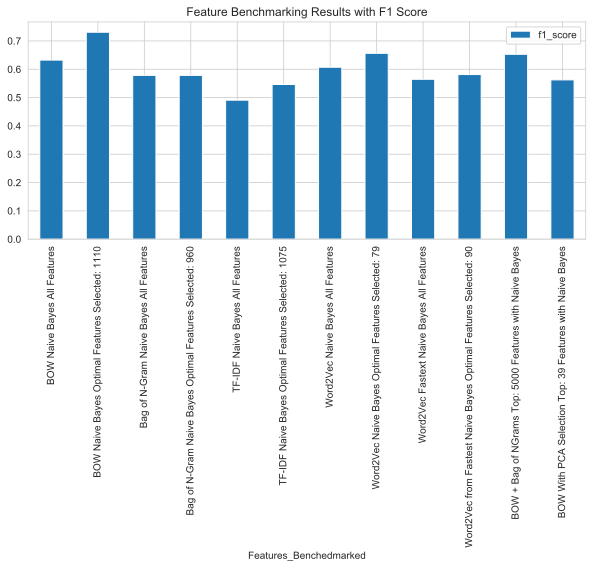

In [143]:
df_benchmarks.plot(x="Features_Benchedmarked", y="f1_score", kind='bar', title="Feature Benchmarking Results with F1 Score", figsize=(10, 4))

#### Confusion Matrix Heat Map of the Predictions fron the Best Resulting Features
#### This gives us a visual on where the model is failing

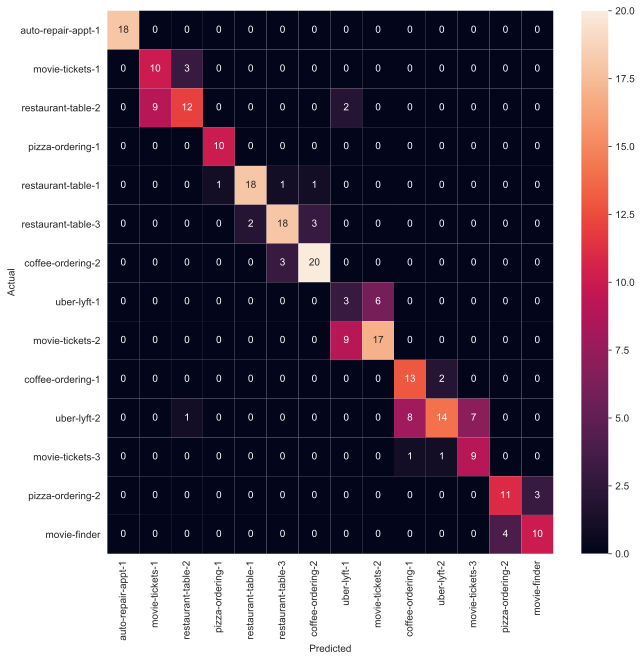

In [127]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm_opt_bow, annot=True, fmt='d',
            xticklabels=category_id_df.Instruction_id.values, yticklabels=category_id_df.Instruction_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()